In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV
from sklearn.base import clone

%matplotlib inline

In [2]:
"""
2010-2018
Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p
Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p

2004-2018
Datasets/data_FEC_NATIONALPOLL_2004_2018.p
Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p
"""

'\n2010-2018\nDatasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p\nDatasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p\n\n2004-2018\nDatasets/data_FEC_NATIONALPOLL_2004_2018.p\nDatasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p\n'

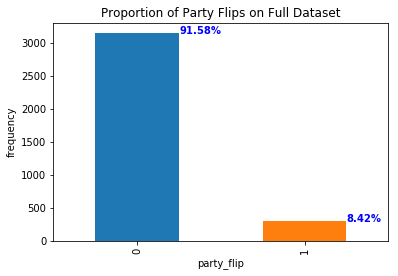

In [3]:
# Plot the proportion of flips in the full dataset

#read in FEC data
full_dataset = pickle.load(open('Datasets/data_FEC_NATIONALPOLL_2004_2018.p', 'rb'))
full_dataset_redistrict = pickle.load(open('Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p', 'rb'))

#add column to indicate a party flip
full_dataset['party_flip'] = (full_dataset.dem_win_prev!=full_dataset.dem_win)*1

#small_dataset.head()
plt.title('Proportion of districts that chage party in consecutive elections')
plt.ylabel('frequency')
plt.xlabel('Party Change')
full_dataset.party_flip.value_counts().plot(kind='bar')

#proportion of districts on the full data that do not flip
full_dataset.groupby('party_flip')['party_flip'].count().plot.bar()
plt.title('Proportion of Party Flips on Full Dataset')

for name, group in (full_dataset.groupby('party_flip')['party_flip']):
    plt.text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/full_dataset.shape[0]*100)+'%', color='blue', fontweight='bold')

C:\Users\m\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


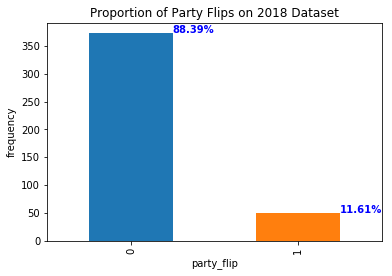

In [4]:
# Plot the proportion of flips in 2018

#add column to indicate a party flip
the_2018_dataset = full_dataset.loc[full_dataset['year']==2018,:]
the_2018_dataset.loc[:,'party_flip'] = (full_dataset.dem_win_prev!=full_dataset.dem_win)*1

#small_dataset.head()
plt.title('Proportion of districts that chage party in consecutive elections')
plt.ylabel('frequency')
plt.xlabel('Party Change')
the_2018_dataset.party_flip.value_counts().plot(kind='bar')

#proportion of districts on the full data that do not flip
the_2018_dataset.groupby('party_flip')['party_flip'].count().plot.bar()
plt.title('Proportion of Party Flips on 2018 Dataset')

for name, group in (the_2018_dataset.groupby('party_flip')['party_flip']):
    plt.text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/the_2018_dataset.shape[0]*100)+'%', color='blue', fontweight='bold')

In [5]:
def upsample(test, monsterframe=False):    
    '''
    input: test (pandas.dataframe)
    output: pandas.dataframe
    
    input dataframe MUST have the columns dem_win_prev and dem_win
    function will ensure that there are an equal number of flips and no flips in the dataset via bootstrap
    '''
    
    #check if party flip as per usual
    test['party_flip'] = (test.dem_win_prev != test.dem_win)*1
    #drop 2018 rows as we want to test on these, don't mess with them
    test = test[test['year'] != 2018]
    #count number of flips and no flips
    print(np.sum((test['party_flip']==1)), np.sum((test['party_flip']==0)))
    #we want to match these counts, so we need target number of bootstrapped samples
    target = (np.sum((test['party_flip']==0))) - (np.sum((test['party_flip']==1)))
    #collect target bootstrap samples where we see a flip
    samples = test[test['party_flip'] == 1].sample(n=target, replace=True)
    #add them back to the dataframe
    test = pd.concat([test, samples])
    print(np.sum((test['party_flip']==1)), np.sum((test['party_flip']==0)))
    print(len(set(test[test['party_flip'] == 1].index)))
    test = test.drop('party_flip', axis=1)
    
    if monsterframe:
        target = 5*(len(test))
        samples = test.sample(n=target, replace=True)
        test = pd.concat([test, samples])
    print(len(test))
    
    
    
    return test

#full_dataset = boostrap(full_dataset)

## Code without demographics

* district
* state
* year
* party
* candidatevotes
* totalvotes
* candidate
* national_poll
* national_poll_prev
* national_poll_delta_subtract
* national_poll_delta_divide
* previous_party
* dem_win_margin_prev
* rep_win_margin_prev
* margin_signed_minus_prev
* margin_signed_divide_prev
* margin_unsigned_minus_prev
* margin_unsigned_divide_prev
* dem_win_prev
* rep_win_prev
* dem_win
* rep_win

## Variables to use

* national_poll
* margin_signed_minus_prev

* dem_win -- response

### Functions

In [20]:
# format data items for input into the model

def format_model_input(filename, cols_to_use, state_hot_encoder=False):
    
    # load full dataset 
    full_dataset = pickle.load(open(filename, 'rb'))
    
    # train data is everything except 2018
    pre_2018_dataset = full_dataset.loc[full_dataset['year']!=2018]
    pre_2018_dataset = upsample(pre_2018_dataset, monsterframe=False)

    X_train = pre_2018_dataset[cols_to_use]
    y_train = pre_2018_dataset['dem_win']
    flip_train = np.abs(pre_2018_dataset['dem_win']-pre_2018_dataset['dem_win_prev'])
    
    # test data is 2018
    the_2018_dataset = full_dataset.loc[full_dataset['year']==2018]
    X_test = the_2018_dataset[cols_to_use]
    y_test = the_2018_dataset['dem_win']
    flip_test = np.abs(the_2018_dataset['dem_win']-the_2018_dataset['dem_win_prev'])
    
    if state_hot_encoder:
        #add one hot encoder for states (with or without dropping first)
        X_train.loc[:,'state'] = pre_2018_dataset['state']
        X_train = pd.get_dummies(X_train,prefix='state',columns=['state'], drop_first=True)
        X_test.loc[:,'state'] = the_2018_dataset['state']
        X_test = pd.get_dummies(X_test,prefix='state',columns=['state'], drop_first=True)
    
    return X_train,y_train, X_test,y_test, flip_train,flip_test

In [17]:
# plot flips predicted by a model

def plot_flips(X_test_input, y_test_input, y_pred_test_input, flip_train, 
               flip_test, model_name):
    
    # copy arrays so you don't accidentally change them 
    X_test = X_test_input.copy()
    y_test = y_test_input.copy()
    y_pred_test = y_pred_test_input.copy()
    
    # add flip data to the array
    X_test['party_flip'] = flip_test
    
    #looking at the missclassifications with logisticRegressionCV
    miss_class_df = X_test[y_test != y_pred_test]
    good_class_df = X_test[y_test == y_pred_test]

    #plot the flips and non flips for each data
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    ax[0].set_title(model_name+' Proportion of party flips on wellclassified test data')
    ax[1].set_title(model_name+' Proportion of party flips missclassified test data')

    if not good_class_df.empty:
        good_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[0])
        for name, group in (good_class_df.groupby('party_flip')['party_flip']):
            ax[0].text(int(name)+.25, group.count() + .25, \
            '{0:.2f}'.format(group.count()/good_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

    if not miss_class_df.empty:
        miss_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[1])
        for name, group in (miss_class_df.groupby('party_flip')['party_flip']):
            ax[1].text(int(name)+.15, group.count() + .25, \
            '{0:.2f}'.format(group.count()/miss_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

    normnoflip = len(X_test[X_test['party_flip'] == 0])
    normflip = len(X_test[X_test['party_flip'] == 1])
    print('predicted correctly. does not flip.: {}'.format(len(good_class_df[good_class_df['party_flip'] == 0])/normnoflip))
    print('predicted wrongly. does not flip.: {}'.format(len(miss_class_df[miss_class_df['party_flip'] == 0])/normnoflip))
    
    print('predicted correctly. does flips.: {}'.format(len(good_class_df[good_class_df['party_flip'] == 1])/normflip))
    print('predicted wrongly. does flips.: {}'.format(len(miss_class_df[miss_class_df['party_flip'] == 1])/normflip))
            
    plt.show()

In [18]:
# print out R2, accuracy, and plot # flipped seats correctly predicted for a given model

def report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder=False):
    
    # read in the desired data
    X_train,y_train, X_test,y_test, flip_train,flip_test = \
        format_model_input(filename, cols_to_use, state_hot_encoder)
        
    fitted_model_dict = {}
    
    print(X_train.shape)
    
    for model_name, model in model_dict.items():
        model_copy = clone(model) # deep copy model to prevent fitting it twice
        print(model_name)

        fitted_model = model_copy.fit(X_train,y_train)
        y_pred_test = fitted_model.predict(X_test)

        print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred_test.round()))

        print("\n{} R2: ".format(model_name), fitted_model.score(X_train,y_train))
        print("{} Test Accuracy".format(model_name), accuracy_score(y_test,y_pred_test.round()))

        plot_flips(X_test, y_test, y_pred_test.round(), flip_train, flip_test, model_name)
        
        fitted_model_dict[model_name] = fitted_model
        
#     print('LASSO Betas')
#     print([i for i in zip(cols_to_use,fitted_model_dict['LASSO'].coef_)])
    
    return fitted_model_dict

### Try out different models and columns

#### Full dataset, no demographics, not dropping any data. 

In [9]:
# specify your models here:
model_dict = {
    'LogRegCV'      : LogisticRegressionCV(cv=5,random_state=209,multi_class='ovr',n_jobs=4),
    'kNN'           : KNeighborsClassifier(n_neighbors=10,n_jobs=4),
    'Random Forest' : RandomForestClassifier(n_jobs=4,random_state=209),
    'AdaBoost'      : AdaBoostClassifier(DecisionTreeClassifier(max_depth=10)),
    'LASSO'         : LassoCV(cv=5)
}

In [ ]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018.p'
cols_to_use = ['national_poll', 'national_poll_prev',
       'national_poll_delta_subtract', 'national_poll_delta_divide',
       'dem_win_margin_prev', 'rep_win_margin_prev',
       'margin_signed_minus_prev', 'margin_signed_divide_prev',
       'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev',
       'dem_win_prev', 'rep_win_prev'] # all of them
state_hot_encoder = False


report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

### Full dataset, no demographics, dropping redistricted states

In [ ]:
# specify columns to use and the file you want to read in 
filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p'
state_hot_encoder = False # some states get dropped so this leads to problems
# cols_to_use same as above

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

### Selected columns in the full dataset, no demographics

In [ ]:
filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev']
state_hot_encoder = False

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

### Selected columns in the full dataset, no demographics, dropping redistricted states

In [ ]:
filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev']
state_hot_encoder = False

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

### Selected columns in the full dataset, no demographics, imputing redistricted states

### Dataset since 2010, with demographics, nothing dropped

columns in demographics


['district', 'state', 'year', 'party', 'candidatevotes', 'totalvotes',
       'candidate', 'national_poll', 'national_poll_prev',
       'national_poll_delta_subtract', 'national_poll_delta_divide',
       'previous_party', 'dem_win_margin_prev', 'rep_win_margin_prev',
       'margin_signed_minus_prev', 'margin_signed_divide_prev',
       'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev',
       'dem_win_prev', 'rep_win_prev', 'dem_win', 'rep_win', 'female_pct',
       'age18_24_pct', 'age25_34_pct', 'median_age', 'unmarried_partner_pct',
       'male_living_alone_pct', 'bachelors_deg_or_higher_pct',
       'past_year_births_to_unmarried_women_pct', 'civilian_veteran_pct',
       'live_same_house_past_year_pct',
       'foreign_born_proportion_from_LatinAmerica',
       'speak_other_language_at_home_pct', 'labor_force_unemployed_pct',
       'public_transit_commuter_pct', 'no_health_insurance_pct',
       'poverty_rate_pct', 'median_housing_value', 'median_household_income',
       'food_stamp_benefits_pct', 'foreign_to_native_born_ratio']

In [10]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
# cols_to_use = ['national_poll', 'national_poll_prev', 'national_poll_delta_subtract', 
#                'national_poll_delta_divide', 'dem_win_margin_prev', 'rep_win_margin_prev',
#                'margin_signed_minus_prev', 'margin_signed_divide_prev', 
#                'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev', 
#                'dem_win_prev', 'rep_win_prev', 'female_pct', 'age18_24_pct', 
#                'age25_34_pct', 'median_age', 'unmarried_partner_pct', 
#                'male_living_alone_pct', 'bachelors_deg_or_higher_pct', 
#                'past_year_births_to_unmarried_women_pct', 'civilian_veteran_pct', 
#                'live_same_house_past_year_pct', 
#                'foreign_born_proportion_from_LatinAmerica', 
#                'speak_other_language_at_home_pct', 'labor_force_unemployed_pct', 
#                'public_transit_commuter_pct', 'no_health_insurance_pct', 
#                'poverty_rate_pct', 'median_housing_value', 'median_household_income', 
#                'food_stamp_benefits_pct', 'foreign_to_native_born_ratio'] # everything
cols_to_use = ['national_poll', 'national_poll_prev', 'national_poll_delta_subtract', 
               'national_poll_delta_divide', 'dem_win_margin_prev', 'rep_win_margin_prev',
               'margin_signed_minus_prev', 'margin_signed_divide_prev', 
               'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev', 
               'dem_win_prev', 'rep_win_prev', 'female_pct', 'age18_24_pct', 
               'age25_34_pct', 'median_age', 'unmarried_partner_pct', 
               'male_living_alone_pct', 'bachelors_deg_or_higher_pct'] # everything

In [ ]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
#cols_to_use = [] # todo
state_hot_encoder = False

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

### Dataset since 2010, with demographics, dropping redistricted states

In [ ]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p'
# cols_to_use same as above
state_hot_encoder = False

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

### Selected columns in dataset since 2010, with demographics, nothing dropped

In [ ]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
#cols_to_use = [] # todo
state_hot_encoder = False

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

### Selected columns in dataset since 2010, with demographics, dropping redistricted states

In [ ]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
# same as before
state_hot_encoder = False

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

## Impute 2010 data into all non-redistricted districts in prior years. 

### Dataset since 2004, with demographics imputed, redistrited states dropped

In [ ]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018_REDISTRICTDROP.p'
#cols = [] # todo
state_hot_encoder = False

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

Idea: variable which is # of tims a district flipped in prior years... or something

## Try different k's for kNN 

In [11]:
cols_to_use.append('latitude')
cols_to_use.append('longitude')
cols_to_use

['national_poll',
 'national_poll_prev',
 'national_poll_delta_subtract',
 'national_poll_delta_divide',
 'dem_win_margin_prev',
 'rep_win_margin_prev',
 'margin_signed_minus_prev',
 'margin_signed_divide_prev',
 'margin_unsigned_minus_prev',
 'margin_unsigned_divide_prev',
 'dem_win_prev',
 'rep_win_prev',
 'female_pct',
 'age18_24_pct',
 'age25_34_pct',
 'median_age',
 'unmarried_partner_pct',
 'male_living_alone_pct',
 'bachelors_deg_or_higher_pct',
 'latitude',
 'longitude']

(2603, 21)
knn1
Confusion Matrix: 
 [[184   3]
 [ 44 173]]

knn1 R2:  0.8866692278140607
knn1 Test Accuracy 0.8836633663366337
predicted correctly. does not flip.: 0.9780821917808219
predicted wrongly. does not flip.: 0.021917808219178082
predicted correctly. does flips.: 0.0
predicted wrongly. does flips.: 1.0


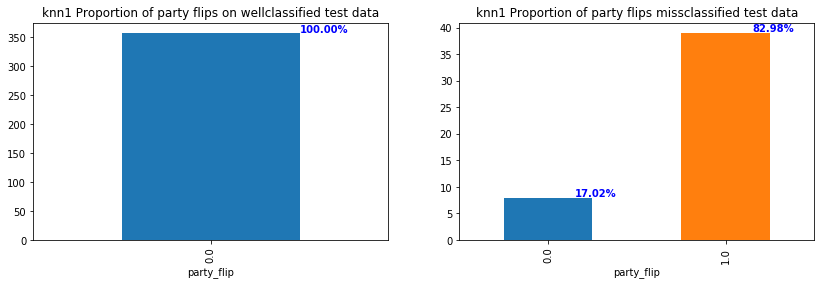

knn6
Confusion Matrix: 
 [[169  18]
 [ 53 164]]

knn6 R2:  0.869765655013446
knn6 Test Accuracy 0.8242574257425742
predicted correctly. does not flip.: 0.8931506849315068
predicted wrongly. does not flip.: 0.10684931506849316
predicted correctly. does flips.: 0.1794871794871795
predicted wrongly. does flips.: 0.8205128205128205


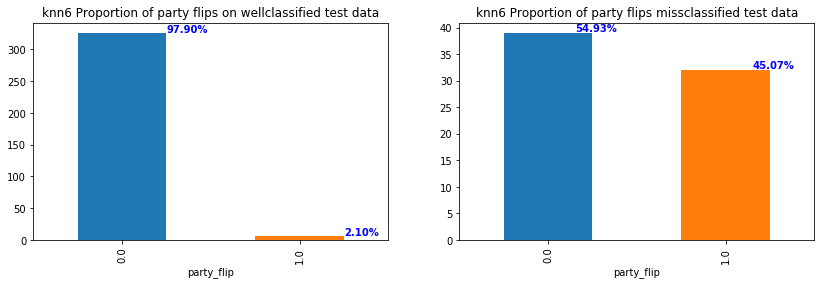

knn11
Confusion Matrix: 
 [[166  21]
 [ 45 172]]

knn11 R2:  0.7733384556281214
knn11 Test Accuracy 0.8366336633663366
predicted correctly. does not flip.: 0.8904109589041096
predicted wrongly. does not flip.: 0.1095890410958904
predicted correctly. does flips.: 0.3333333333333333
predicted wrongly. does flips.: 0.6666666666666666


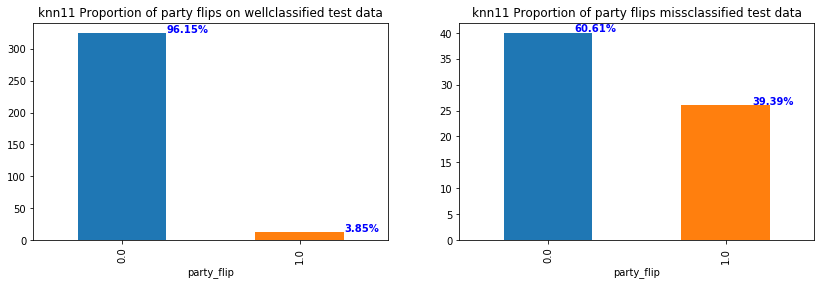

knn16
Confusion Matrix: 
 [[160  27]
 [ 67 150]]

knn16 R2:  0.7468305800998848
knn16 Test Accuracy 0.7673267326732673
predicted correctly. does not flip.: 0.810958904109589
predicted wrongly. does not flip.: 0.18904109589041096
predicted correctly. does flips.: 0.358974358974359
predicted wrongly. does flips.: 0.6410256410256411


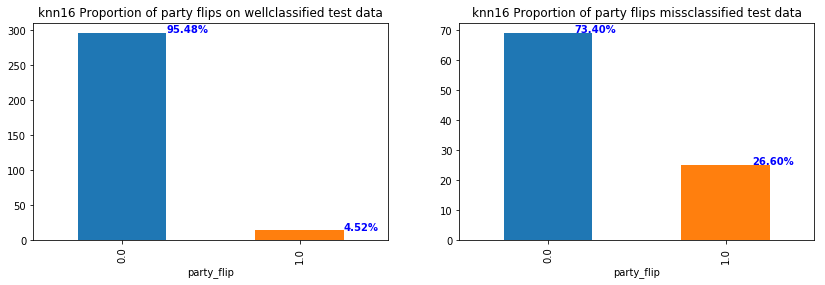

knn21
Confusion Matrix: 
 [[153  34]
 [ 62 155]]

knn21 R2:  0.7468305800998848
knn21 Test Accuracy 0.7623762376237624
predicted correctly. does not flip.: 0.7972602739726027
predicted wrongly. does not flip.: 0.20273972602739726
predicted correctly. does flips.: 0.4358974358974359
predicted wrongly. does flips.: 0.5641025641025641


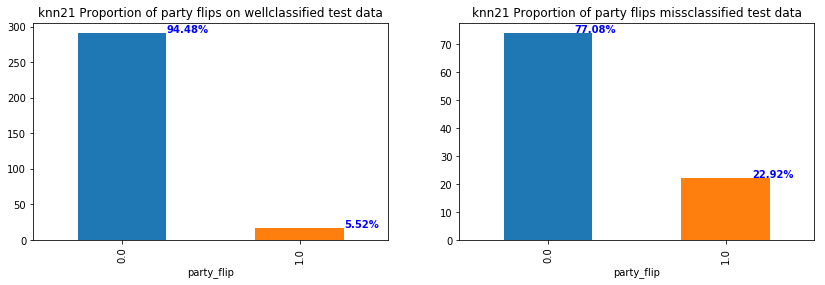

knn26
Confusion Matrix: 
 [[156  31]
 [ 68 149]]

knn26 R2:  0.7149442950441798
knn26 Test Accuracy 0.754950495049505
predicted correctly. does not flip.: 0.7835616438356164
predicted wrongly. does not flip.: 0.21643835616438356
predicted correctly. does flips.: 0.48717948717948717
predicted wrongly. does flips.: 0.5128205128205128


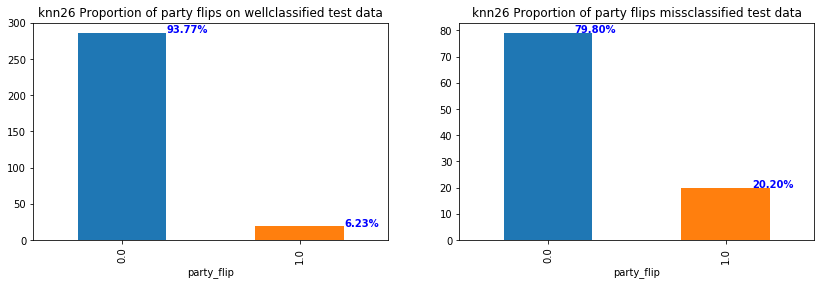

In [19]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018_REDISTRICTDROP.p'
ks = np.arange(1,30, 5)
state_hot_encoder = False

model_dict = {}

def mydist(x, y):
    if all(x == y):
        #bootstrap sample likely
        return 1e10
    lonx, latx = x[-2:]
    lony, laty = y[-2:]
    
    return ((lonx-lony)**2 + (latx-laty)**2)**0.5
    
for ka in ks:
    
    model_dict['knn{}'.format(ka)] = KNeighborsClassifier(n_neighbors=ka,n_jobs=4, metric=mydist)

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

C:\Users\m\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


167 2436
2436 2436
167
4872
(4872, 21)
knn1
Confusion Matrix: 
 [[184   3]
 [ 44 173]]

knn1 R2:  0.5465927750410509
knn1 Test Accuracy 0.8836633663366337
predicted correctly. does not flip.: 0.9780821917808219
predicted wrongly. does not flip.: 0.021917808219178082
predicted correctly. does flips.: 0.0
predicted wrongly. does flips.: 1.0


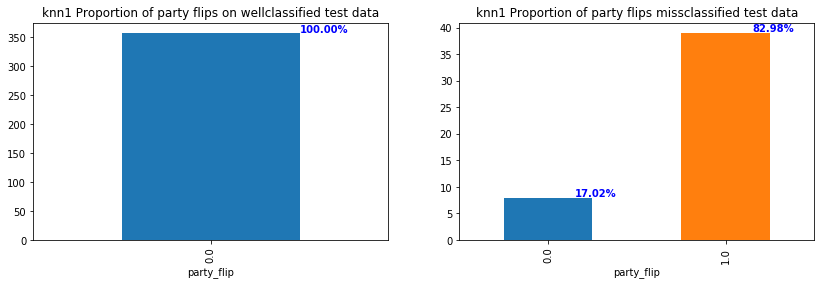

knn6
Confusion Matrix: 
 [[163  24]
 [ 44 173]]

knn6 R2:  0.5334564860426929
knn6 Test Accuracy 0.8316831683168316
predicted correctly. does not flip.: 0.8931506849315068
predicted wrongly. does not flip.: 0.10684931506849316
predicted correctly. does flips.: 0.2564102564102564
predicted wrongly. does flips.: 0.7435897435897436


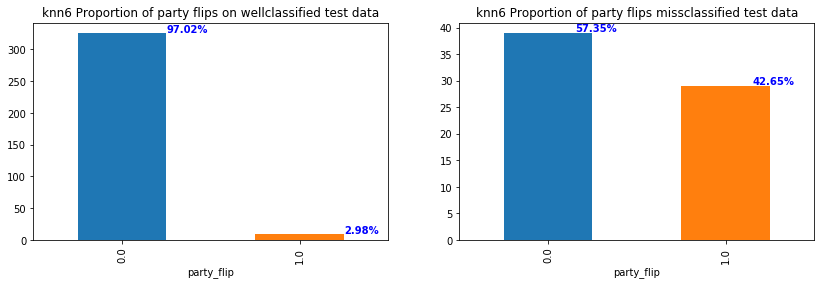

knn11
Confusion Matrix: 
 [[157  30]
 [ 41 176]]

knn11 R2:  0.4573070607553366
knn11 Test Accuracy 0.8242574257425742
predicted correctly. does not flip.: 0.8794520547945206
predicted wrongly. does not flip.: 0.12054794520547946
predicted correctly. does flips.: 0.3076923076923077
predicted wrongly. does flips.: 0.6923076923076923


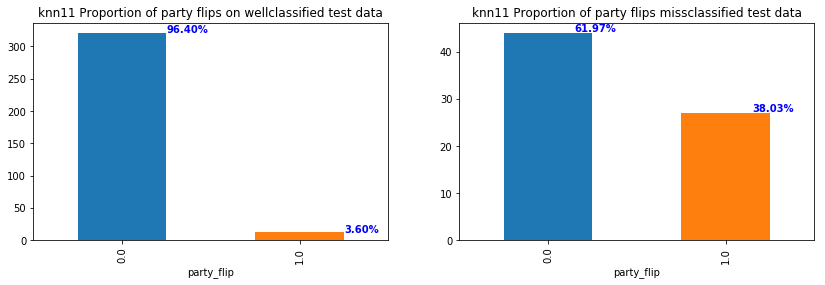

knn16
Confusion Matrix: 
 [[141  46]
 [ 56 161]]

knn16 R2:  0.45463875205254517
knn16 Test Accuracy 0.7475247524752475
predicted correctly. does not flip.: 0.7835616438356164
predicted wrongly. does not flip.: 0.21643835616438356
predicted correctly. does flips.: 0.41025641025641024
predicted wrongly. does flips.: 0.5897435897435898


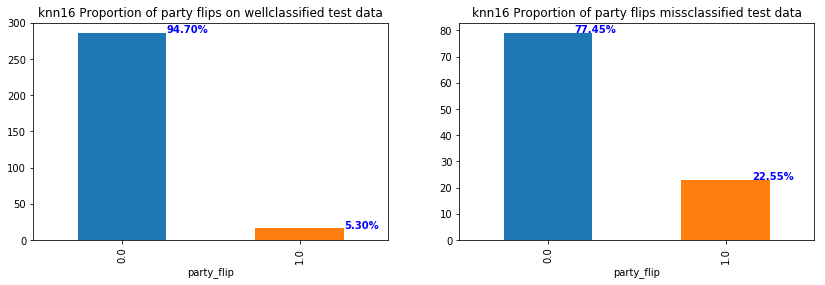

knn21
Confusion Matrix: 
 [[131  56]
 [ 50 167]]

knn21 R2:  0.44376026272577995
knn21 Test Accuracy 0.7376237623762376
predicted correctly. does not flip.: 0.7643835616438356
predicted wrongly. does not flip.: 0.2356164383561644
predicted correctly. does flips.: 0.48717948717948717
predicted wrongly. does flips.: 0.5128205128205128


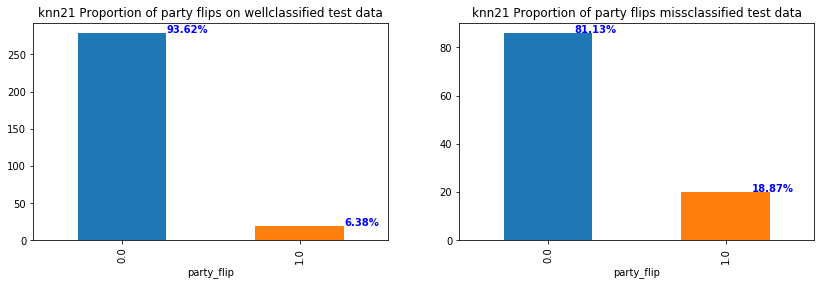

knn26
Confusion Matrix: 
 [[136  51]
 [ 57 160]]

knn26 R2:  0.4628489326765189
knn26 Test Accuracy 0.7326732673267327
predicted correctly. does not flip.: 0.7589041095890411
predicted wrongly. does not flip.: 0.2410958904109589
predicted correctly. does flips.: 0.48717948717948717
predicted wrongly. does flips.: 0.5128205128205128


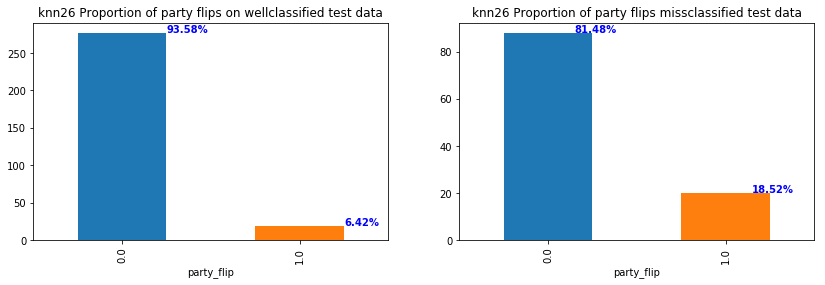

In [15]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018_REDISTRICTDROP.p'
ks = np.arange(1,30, 5)
state_hot_encoder = False

model_dict = {}

def mydist(x, y):
    if all(x == y):
        #bootstrap sample likely
        return 1e10
    lonx, latx = x[-2:]
    lony, laty = y[-2:]
    
    return ((lonx-lony)**2 + (latx-laty)**2)**0.5
    
for ka in ks:
    
    model_dict['knn{}'.format(ka)] = KNeighborsClassifier(n_neighbors=ka,n_jobs=4, metric=mydist)

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

###  NOTES:

1. Logistic CV 90% of the missclassified data occurs when there is a change of party compared to the previous year. No state flips are predicted correctly. 
2. KNN, 100% of the missclassified data occurs when there is a change of party. 5% of the well classified data is party flip. (Better performance)
3. Predicts correctly 100% of the districts that do not change, and ...

Concentrate on improving the states that flip to a different party between elections

Ideas
0. Try non-linear approaches (KNN, Random Forest and Boosting)
1. Increase data by Upsampling and downsampling
2. Increase data by adding more historical data
3. Add demographics data
4. Add redistricting